In [4]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
img_dir = '../output/img'
mask1_dir = '../output/circle'
mask2_dir = '../output/ring'
# img_files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

In [159]:
img_files = img_files[::3]
img_files.append('Snipaste_2025-01-12_02-30-03.jpg')
img_files.append('Snipaste_2025-01-12_02-31-04.jpg')

img_files = ['Snipaste_2025-01-12_02-31-04.jpg']

img_files

['Snipaste_2025-01-12_02-31-04.jpg']

In [160]:
img_pack = []
for img_file in img_files:

    mask1_path = os.path.join(mask1_dir, img_file)  # 根据实际情况调整扩展名
    mask2_path = os.path.join(mask2_dir, img_file)  # 同上

    img_path = os.path.join(img_dir, img_file)

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 读取彩色图像
    mask1 = cv2.imread(mask1_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像作为mask
    mask2 = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像作为mask
    # 将mask转换为布尔型numpy数组
    mask1_bool = mask1 > 0  # 假设非零像素代表mask区域
    mask2_bool = mask2 > 0  # 同上
    # 返回一个三元组
    img_pack.append((img, mask1_bool, mask2_bool))

In [6]:
import matplotlib.pyplot as plt

In [2]:
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(6, 6))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

In [163]:
def display_images(image_list):
    # 确保我们不会超过16张图片
    num_images = len(image_list)
    if num_images > 16:
        raise ValueError("Image list contains more than 16 images.")

    # 创建4x4子图布局
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # 展示图片
    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            # 假设image_list中的元素是图像数据或路径
            # 这里需要根据实际情况调整为加载图片的正确方式
            img = image_list[idx]  # 如果已经是图像数据，则直接使用
            # 如果是文件路径，可以使用plt.imread(img) 或其他图像读取方法
            image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(image_rgb)
            ax.set_title(f'Image {idx + 1}')
        else:
            # 如果没有足够的图片填充4x4网格，则保持剩余子图为空
            ax.axis('off')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

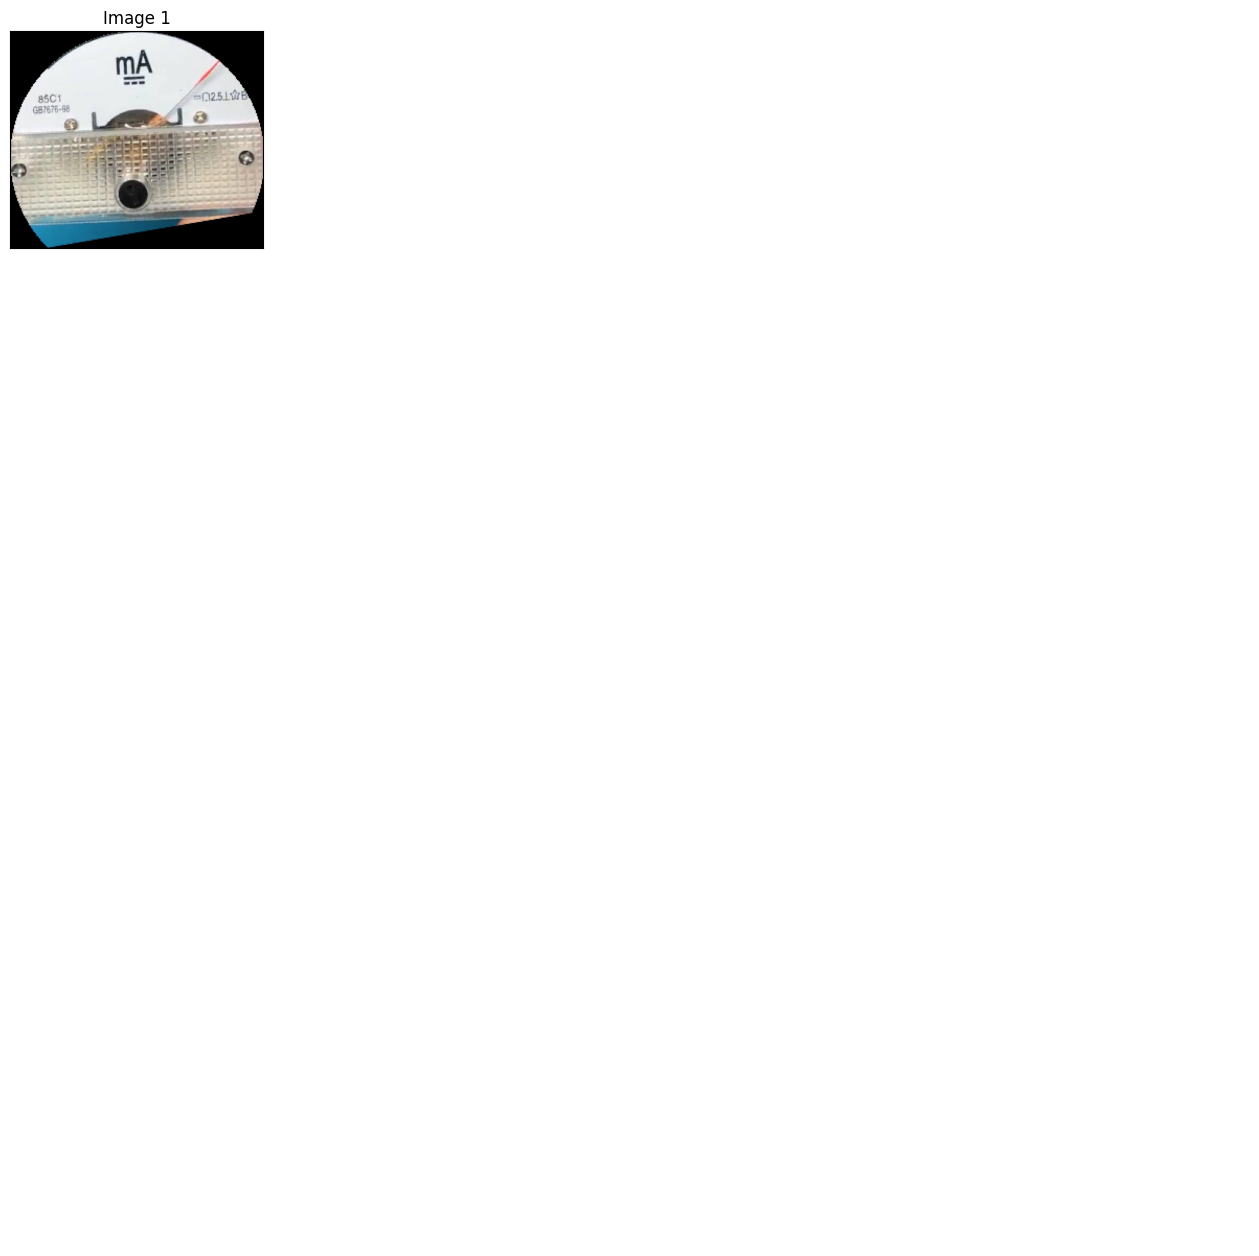

In [164]:
imgs = []
for img, mask1_bool, mask2_bool in img_pack:
   imgs.append(img)

display_images(imgs)

图像处理测试

In [165]:
def adjust_gamma(image, gamma=1.0):
    """
    对输入图像进行伽玛校正。

    参数:
        image (numpy.ndarray): 输入图像。
        gamma (float): 伽玛值，用于控制亮度调整的程度。

    返回:
        numpy.ndarray: 经过伽玛校正后的图像。
    """

    # 构建伽玛查找表
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")

    # 应用伽玛校正到图像
    return cv2.LUT(image, table)


def adaptive_equalization(gray_img, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    使用自适应直方图均衡化（CLAHE）对输入图像进行处理。

    参数:
        gray_img (numpy.ndarray): 输入的灰度图像。
        clip_limit (float): 每个tile的对比度限制，超过该值的直方图bin会被裁剪并重新分配。
                            较低的值可以减少噪声放大。
        tile_grid_size (tuple): 将图像划分成多少个小块进行均衡化，默认是8x8。

    返回:
        numpy.ndarray: 自适应直方图均衡化后的灰度图像。
    """

    # 创建一个 CLAHE 对象
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # 应用 CLAHE 到输入图像
    equalized_img = clahe.apply(gray_img)

    return equalized_img

In [166]:
def kmeans_binarization(gray_img, mask):
    """
    对输入图像应用中值滤波去噪和K-means聚类进行二值化。
    仅对 mask 为 True 的像素点进行处理。

    参数:
        gray_img (numpy.ndarray): 输入的灰度图像。
        mask (numpy.ndarray): 布尔类型掩码，True 表示需要处理的像素，False 表示保留原始值。

    返回:
        numpy.ndarray: 二值化后的灰度图像。
    """
    # 确保 mask 和图像尺寸一致
    assert gray_img.shape == mask.shape, "gray_img 和 mask 必须尺寸相同"

    # 提取需要处理的像素
    pixel_vals = gray_img[mask].reshape((-1, 1))

    # 转换为浮点数类型
    pixel_vals = np.float32(pixel_vals)

    # 定义终止条件（迭代10次或移动1.0）
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # 执行 K-means 聚类
    _, labels, centers = cv2.kmeans(pixel_vals, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # 获取质心并排序，以确定哪个是背景，哪个是前景
    sorted_centers = np.sort(centers, axis=0)

    # 创建二值图像
    threshold_value = sorted_centers.mean()  # 取两个质心的中间值作为阈值
    binary_vals = np.where(pixel_vals > threshold_value, 255, 0).astype(np.uint8)

    # 创建与原图像同尺寸的二值图像
    binary_img = gray_img.copy()
    binary_img[mask] = binary_vals.flatten()  # 仅更新 mask 中的像素

    return binary_img

In [167]:
def closed(img, mask, kernel_size=5):


    # 创建一个与原图相同大小的结果图像副本
    result = img.copy()

    # 使用 mask 提取需要处理的区域
    region_of_interest = img[mask]

    # 定义结构元素（内核）
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # 创建一个临时图像，仅包含需要处理的区域
    temp_img = np.zeros_like(img)
    temp_img[mask] = region_of_interest

    # 执行闭运算：先膨胀后腐蚀
    temp_closed = cv2.morphologyEx(temp_img, cv2.MORPH_CLOSE, kernel)

    # 将闭运算的结果放回原图对应位置
    result[mask] = temp_closed[mask]

    return result

In [168]:
from skimage.morphology import skeletonize

def skeletonize_with_skimage(img, mask):

    # 创建一个与原图相同大小的结果图像副本
    skeleton = img.copy()

    # 使用 mask 提取需要处理的区域
    region_of_interest = img[mask]

    # 创建一个临时图像，仅包含需要处理的区域
    temp_img = np.zeros_like(img, dtype=bool)
    temp_img[mask] = region_of_interest.astype(bool)

    # 应用骨架化
    temp_skel = skeletonize(temp_img)

    # 将骨架化结果放回原图对应位置
    skeleton[mask] = temp_skel[mask].astype(np.uint8) * 255  # 转换回原来的值域

    return skeleton

In [169]:
def process(img, mask1, mask2, debug=False):

    # Step 1: Apply mask1 to the image
    masked_img = cv2.bitwise_and(img, img, mask=mask1.astype(np.uint8))
    if debug: show_img(masked_img)

    gamma_img = adjust_gamma(masked_img, 1.5)
    if debug: show_img(gamma_img)
    # show_img(masked_img)
    # show_img(gamma_img)

    # Step 2: Apply bilateral filtering on the masked image
    filtered_img = cv2.bilateralFilter(masked_img, d=9, sigmaColor=75, sigmaSpace=75)
    if debug: show_img(filtered_img)

    # Step 3: Convert the image to grayscale for histogram equalization
    gray_img = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)
    if debug: show_img(gray_img)

    # Step 4: Perform histogram equalization
    equalized_img = adaptive_equalization(gray_img)
    if debug: show_img(equalized_img)

    # Step 5: Apply K-means clustering for binarization
    binary_img = 255 - kmeans_binarization(equalized_img, mask2)
    if debug: show_img(binary_img)

    closed_img = closed(binary_img, mask2)
    if debug: show_img(closed_img)

    skeleton_img = skeletonize_with_skimage(closed_img, mask2)
    return skeleton_img


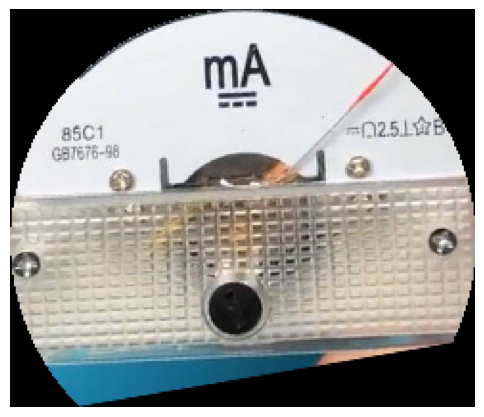

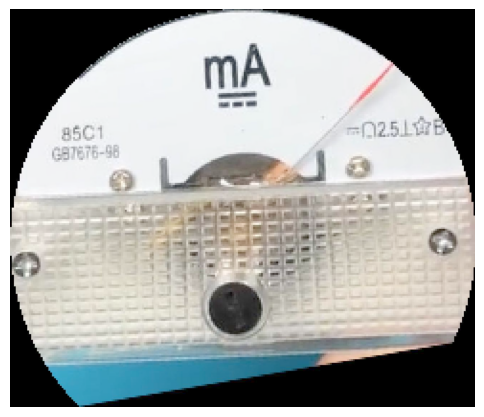

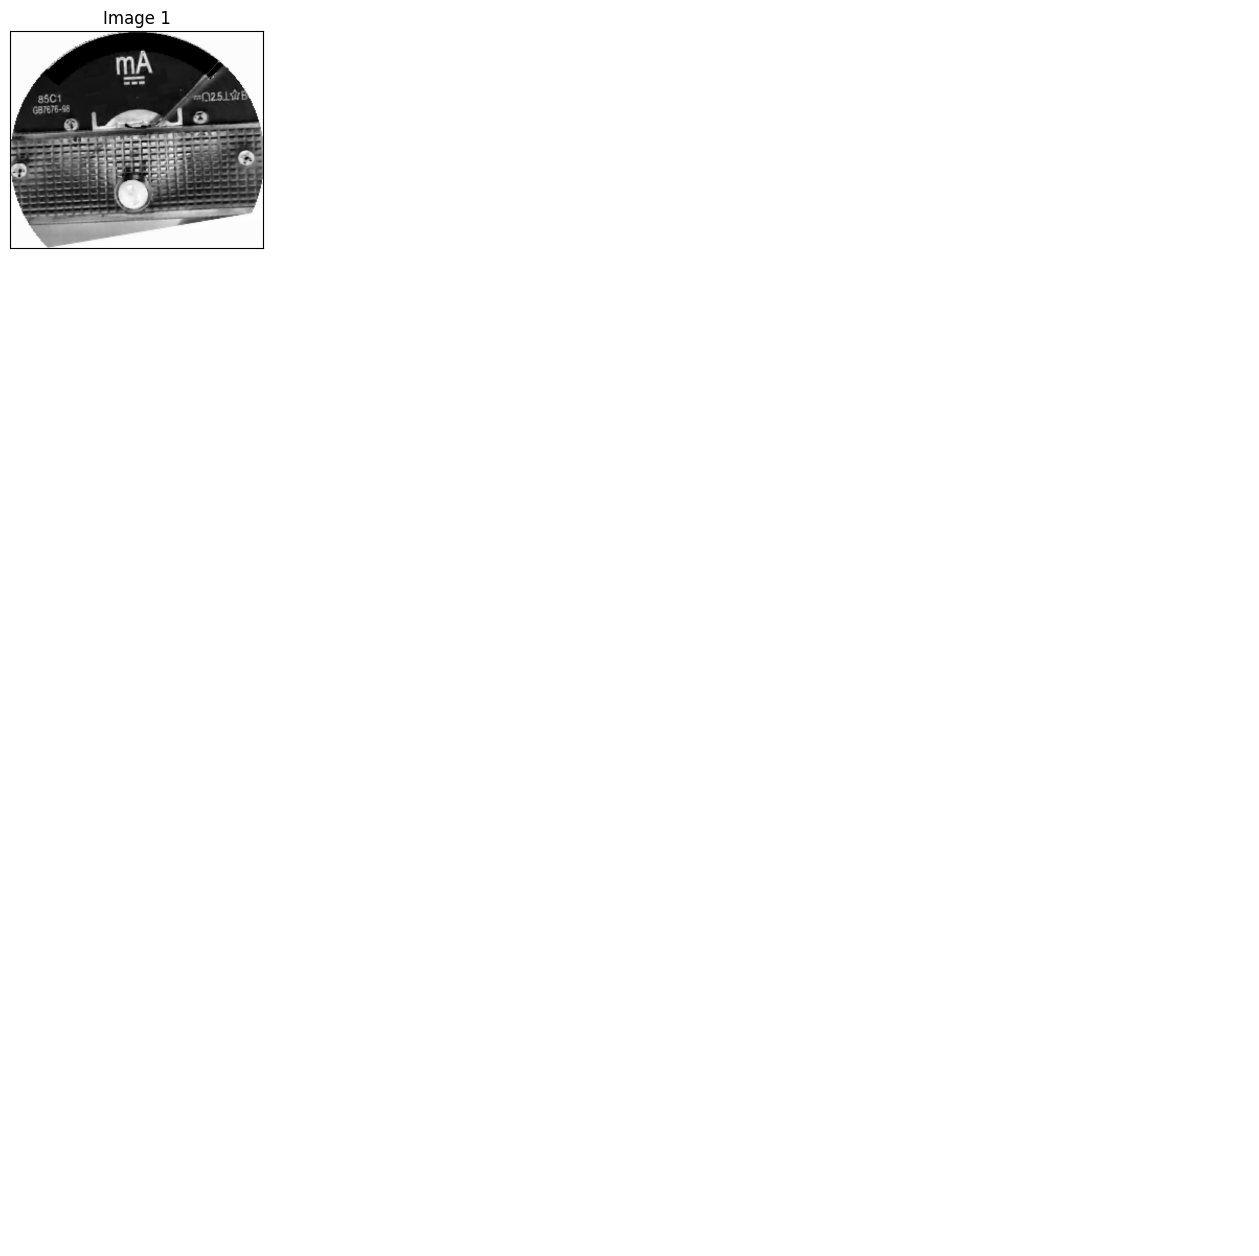

In [170]:


imgs = []
for img, mask1_bool, mask2_bool in img_pack:


   imgs.append(process(img, mask1_bool, mask2_bool, False))

display_images(imgs)



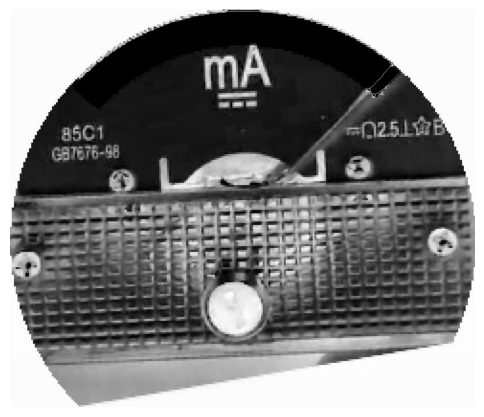

In [171]:
for img in imgs:
    show_img(img)

In [1]:
import numpy as np

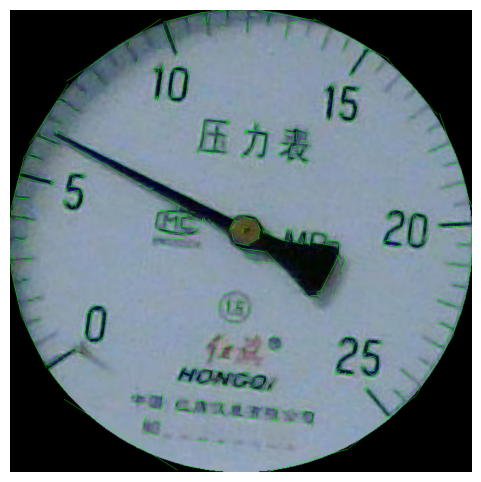

In [8]:
import cv2
import numpy as np

# 读取图像并转换为灰度图
image = cv2.imread('../output/img/54.jpg', cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 创建一个LSD对象
lsd = cv2.createLineSegmentDetector(0)

# 检测线段
lines = lsd.detect(gray)[0]  # 返回的是一个元组，我们只需要第一项

# 绘制检测到的线段
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = map(int, line[0])
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 1)

show_img(image)